In [ ]:
from  utils.preprocessing_utils import parse_data,build_dataframe_from_json,set_seed,get_rows_containing_label
import utils.plot_utils as pltUtils
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from utils.source_code_feature_extractor import SourceCodeFeatureExtractor
from scipy.sparse import hstack, csr_matrix
from utils.training_config import TrainingConfig
from sklearn.metrics import f1_score
from utils.training_utils import analyze_tag_confusions
from collections import Counter
import re 

# Data loading into a dataframe

In [7]:
set_seed(42)

jsonList = parse_data()


100%|██████████| 4982/4982 [00:00<00:00, 9301.40it/s]


# Data analysis

In [3]:

pltUtils.plot_tags_names_repartition(dataframe["tags"])
probability_count = sum("probabilities" in tags for tags in dataframe["tags"])
print(f"Nombre d'exemples avec le tag 'probabilities' : {probability_count} sur {len(dataframe)}")

NameError: name 'dataframe' is not defined

In [4]:
config = TrainingConfig(tags=['math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities'])
dataframe = build_dataframe_from_json(jsonList,config)

dataframe.head()

,prob_desc_time_limit,prob_desc_sample_outputs,src_uid,prob_desc_notes,prob_desc_description,prob_desc_output_spec,prob_desc_input_spec,prob_desc_output_to,prob_desc_input_from,lang,...,file_name,code_uid,prob_desc_memory_limit,prob_desc_sample_inputs,exec_outcome,source_code,prob_desc_created_at,tags,hidden_unit_tests,description_and_code
0,2 seconds,"[""2\n2 4\n3 3\n3 1""]",591372383cf3624f69793c41370022de,None,"Numbers $$$1, 2, 3, \dots n$$$ (each integer f...","For each test case, in the first line, print t...",The first line contains one integer $$$t$$$ ($...,standard output,standard input,Python 3,...,train_000.jsonl,88084dde61bbebdebe163309a2bda179,256 megabytes,"[""1\n4""]",PASSED,\ndef ii(): return int(input())\ndef mi(): ret...,1602407100,[math],,"Numbers $$$1, 2, 3, \dots n$$$ (each integer f..."
1,3 seconds,"[""4\n10\n4\n0""]",afcd41492158e68095b01ff1e88c3dd4,"NoteIn the first test case of the example, the...","There are $$$n$$$ positive integers $$$a_1, a_...",For $$$t$$$ test cases print the answers in th...,The first line of the input contains one integ...,standard output,standard input,Python 3,...,train_000.jsonl,df0e2ae03513f2b9280e19a1df6c8d84,256 megabytes,"[""4\n6\n40 6 40 3 20 1\n1\n1024\n4\n2 4 8 16\n...",PASSED,a = int(input())\nfor i in range(a):\n f = ...,1576321500,[number theory],,"There are $$$n$$$ positive integers $$$a_1, a_..."
2,2 seconds,"[""5"", ""16"", ""18""]",e52ec2fa5bcf5d2027d57b0694b4e15a,NoteIn the first example it is possible to con...,You are given an undirected graph consisting o...,Print one integer — the minimum number of coin...,The first line contains two integers $$$n$$$ a...,standard output,standard input,Python 3,...,train_000.jsonl,d045b0ecd6aaad78a2574780f55d22a1,256 megabytes,"[""3 2\n1 3 3\n2 3 5\n2 1 1"", ""4 0\n1 3 3 7"", ""...",PASSED,def read_nums():\n return [int(x) for x in ...,1545921300,[graphs],,You are given an undirected graph consisting o...
3,1 second,"[""2\n5000 9\n1\n7 \n4\n800 70 6 9000 \n1\n1000...",cd2519f4a7888b2c292f05c64a9db13a,None,A positive (strictly greater than zero) intege...,Print $$$t$$$ answers to the test cases. Each ...,The first line contains an integer $$$t$$$ ($$...,standard output,standard input,PyPy 3,...,train_000.jsonl,52a2313fac7f87cb6696ab7b8e4dc447,256 megabytes,"[""5\n5009\n7\n9876\n10000\n10""]",PASSED,t = int(input())\nfor i in range(t):\n canP...,1590154500,[math],,A positive (strictly greater than zero) intege...
5,1 second,"[""1"", ""0""]",a34f2aa89fe0e78b495b20400d73acf1,NoteThe first test case corresponds to the tre...,You are given a tree with $$$n$$$ vertices. Yo...,Print a single integer — the minimum number o...,The first line contains an integer $$$n$$$ ($$...,standard output,standard input,PyPy 3,...,train_005.jsonl,62ef7edca328924e63757b39c5d42156,256 megabytes,"[""6\n4 5\n2 6\n3 2\n1 2\n2 4"", ""4\n2 4\n4 1\n3...",PASSED,import sys\nfrom collections import defaultdic...,1593873900,"[graphs, trees]",,You are given a tree with $$$n$$$ vertices. Yo...


In [8]:
config = TrainingConfig(tags=['math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities'])
dataframe = build_dataframe_from_json(jsonList,config)

codeFeatureExtractor = SourceCodeFeatureExtractor()
codeFeatureExtractor.transform(dataframe)
#codeFeatureExtractor.add_feature_to_keep("difficulty")
extra_features = dataframe[codeFeatureExtractor.get_training_features()]
extra_features_clean = extra_features.astype(float)
X_extra = csr_matrix(extra_features_clean.values*0.1)

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2),stop_words='english', lowercase=True,max_df=0.8)
X = tfidf.fit_transform(dataframe['description_and_code'])

X = hstack([X,X_extra])

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataframe['tags'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = OneVsRestClassifier(LogisticRegression(max_iter=1000,class_weight='balanced'))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

               precision    recall  f1-score   support

        games       0.89      0.86      0.87        28
     geometry       0.60      0.82      0.69        33
       graphs       0.67      0.75      0.71       121
         math       0.76      0.83      0.80       273
number theory       0.38      0.68      0.49        63
probabilities       0.53      0.53      0.53        19
      strings       0.75      0.80      0.77        60
        trees       0.57      0.62      0.60        69

    micro avg       0.66      0.77      0.71       666
    macro avg       0.64      0.74      0.68       666
 weighted avg       0.68      0.77      0.72       666
  samples avg       0.67      0.79      0.70       666



C:\Users\francois.le-guernic\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:


r = analyze_tag_confusions(y_test,y_pred,mlb.classes_)
print(r["number theory"])
print(r["probabilities"])
print(r["trees"])

math        13
trees        4
graphs       4
games        2
geometry     1
strings      1
Name: count, dtype: int64
math             7
graphs           2
trees            1
number theory    1
Name: count, dtype: int64
graphs           9
math             7
number theory    2
geometry         2
strings          1
Name: count, dtype: int64


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

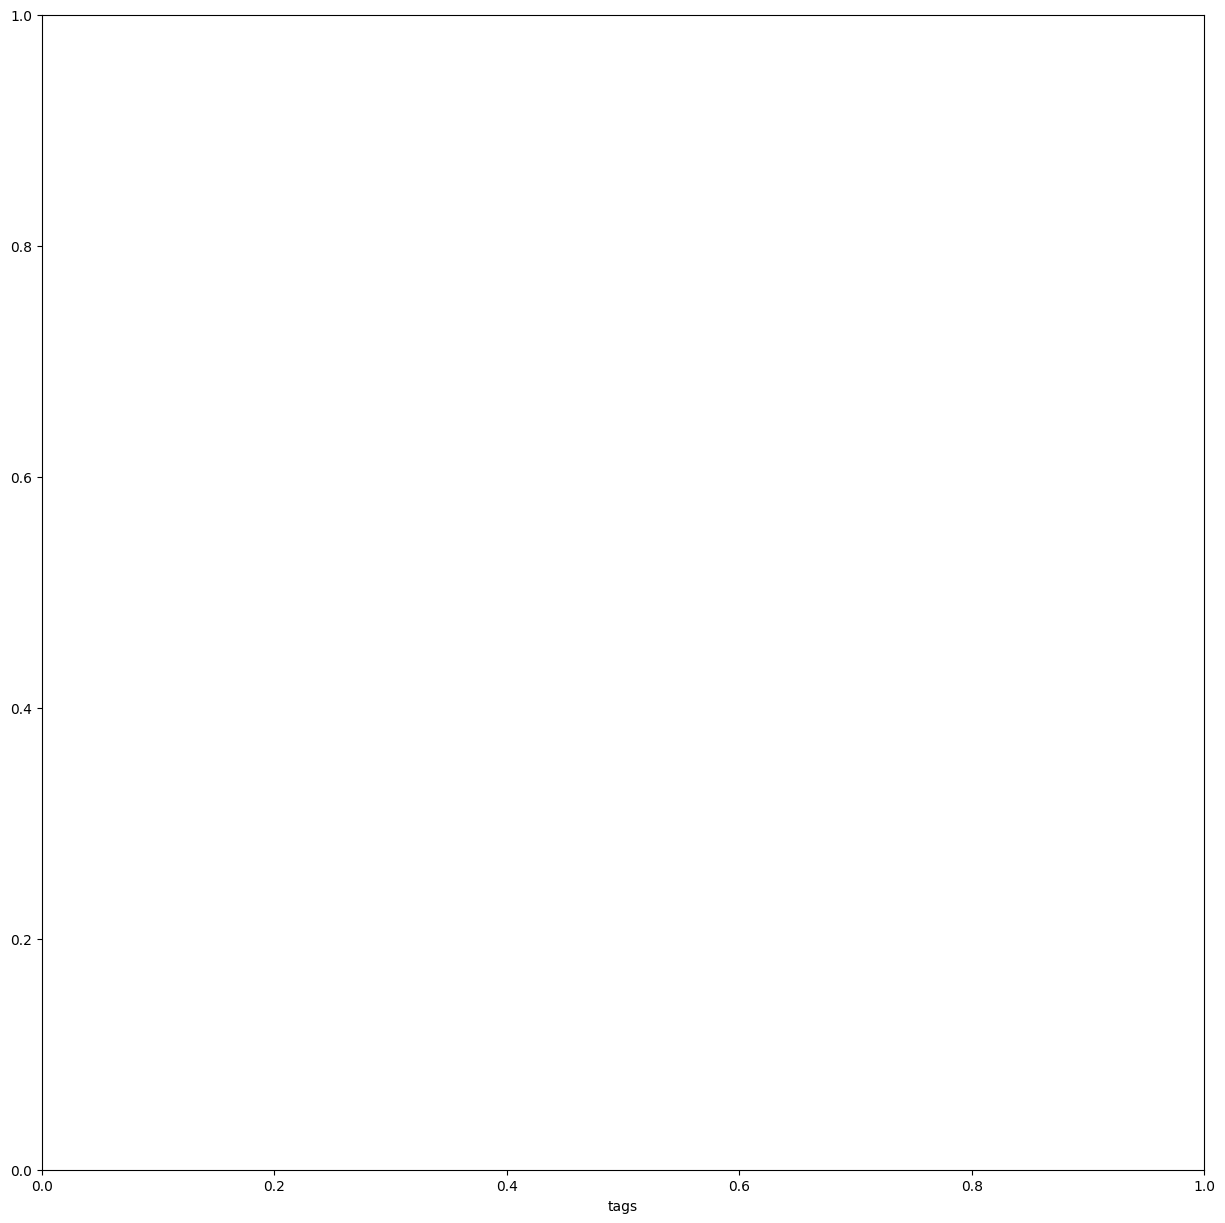

In [51]:
df_exploded = dataframe.explode("tags")
df_exploded.boxplot(column="prob_desc_time_limit",by="tags",figsize=(15,15),rot=90)


In [20]:
df_bs  = get_rows_containing_label("number theory",dataframe)
for i in df_bs["prob_desc_description"].index:
    print(df_bs["prob_desc_description"][i],"\n")

There are $$$n$$$ positive integers $$$a_1, a_2, \dots, a_n$$$. For the one move you can choose any even value $$$c$$$ and divide by two all elements that equal $$$c$$$.For example, if $$$a=[6,8,12,6,3,12]$$$ and you choose $$$c=6$$$, and $$$a$$$ is transformed into $$$a=[3,8,12,3,3,12]$$$ after the move.You need to find the minimal number of moves for transforming $$$a$$$ to an array of only odd integers (each element shouldn't be divisible by $$$2$$$). 

This is an interactive problem.Misha likes to play cooperative games with incomplete information. Today he suggested ten his friends to play a cooperative game "Lake".Misha has already come up with a field for the upcoming game. The field for this game is a directed graph consisting of two parts. The first part is a road along the coast of the lake which is a cycle of $$$c$$$ vertices. The second part is a path from home to the lake which is a chain of $$$t$$$ vertices, and there is an edge from the last vertex of this chain to the v

In [26]:
def get_most_frequent_words(df, n=20, lowercase=True):
    all_words = []
    for text in df["prob_desc_description"].dropna():
        if lowercase:
            text = text.lower()
        words = re.findall(r"\b\w+\b", text)
        all_words.extend(words)
    
    return Counter(all_words).most_common(n)


In [27]:
numberTheory = get_rows_containing_label("number theory",dataframe)
proba = get_rows_containing_label("num",dataframe)
math = get_rows_containing_label("math",dataframe)

print(f"most frequent number theory : ",get_most_frequent_words(numberTheory))
print(f"most frequent math: ",get_most_frequent_words(math))
print(f"most frequent proba : ",get_most_frequent_words(proba))

NameError: name 're' is not defined

In [49]:
proba

,prob_desc_time_limit,prob_desc_sample_outputs,src_uid,prob_desc_notes,prob_desc_description,prob_desc_output_spec,prob_desc_input_spec,prob_desc_output_to,prob_desc_input_from,lang,...,source_code,prob_desc_created_at,tags,hidden_unit_tests,description_and_code,has_math_terms,num_loops,has_comparison_operator,has_probability_terms_in_desc,lencode
1,3 seconds,"[""4\n10\n4\n0""]",afcd41492158e68095b01ff1e88c3dd4,"NoteIn the first test case of the example, the...","There are $$$n$$$ positive integers $$$a_1, a_...",For $$$t$$$ test cases print the answers in th...,The first line of the input contains one integ...,standard output,standard input,Python 3,...,a = int(input())\nfor i in range(a):\n f = ...,1576321500,[number theory],,"There are $$$n$$$ positive integers $$$a_1, a_...",1,3,False,0,271
12,1 second,"[""next 0 5\n\nnext 0 1 3\n\nnext 2 3 0 1 4 5 6...",b2ea06e06e60adf88e601f1164c360cd,NoteIn the sample input and output values are ...,This is an interactive problem.Misha likes to ...,"After all friends gather at the finish vertex,...",There is no input — go to the interaction part...,standard output,standard input,Python 3,...,"def move(s):\n print('next', s)\n return...",1552035900,[number theory],,This is an interactive problem.Misha likes to ...,1,2,False,0,195
25,1 second,"[""72900"", ""317451037""]",6fcd8713af5a108d590bc99da314cded,"NoteIn the first example, $$$f_{4} = 90$$$, $$...",Let $$$f_{x} = c^{2x-6} \cdot f_{x-1} \cdot f_...,Print $$$f_{n} \bmod (10^{9} + 7)$$$.,"The only line contains five integers $$$n$$$, ...",standard output,standard input,Python 3,...,"def mat_mul(a, b):\n n, m, p = len(a), len(...",1560258300,"[number theory, math]",,Let $$$f_{x} = c^{2x-6} \cdot f_{x-1} \cdot f_...,1,4,False,0,899
27,1 second,"[""YES\n1 0\n2 3\n4 1"", ""NO""]",5c026adda2ae3d7b707d5054bd84db3f,NoteIn the first example area of the triangle ...,"Vasya has got three integers $$$n$$$, $$$m$$$ ...","If there are no such points, print ""NO"". Other...",The single line contains three integers $$$n$$...,standard output,standard input,PyPy 3,...,"#Code by Sounak, IIESTS\n#--------------------...",1537707900,"[number theory, geometry]",,"Vasya has got three integers $$$n$$$, $$$m$$$ ...",1,5,True,0,2744
35,2 seconds,"[""YES\n2 4 8 \nNO\nNO\nNO\nYES\n3 5 823""]",0f7ceecdffe11f45d0c1d618ef3c6469,None,You are given one integer number $$$n$$$. Find...,"For each test case, print the answer on it. Pr...",The first line of the input contains one integ...,standard output,standard input,Python 3,...,def factors(n):\n factor = []\n for i in...,1579703700,"[number theory, math]",,You are given one integer number $$$n$$$. Find...,1,4,False,0,663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,2 seconds,"[""2\n1\n0\n3\n17\n1111""]",e8f12eb9144ac2ea1c18fbfb15a84a0e,NoteIn query one the suitable numbers are 1 an...,"You're given Q queries of the form (L, R). For...",Output Q lines — the answers to the queries.,The first line contains the number of queries ...,standard output,standard input,PyPy 2,...,"import math\nfrom sys import stdin, stdout \nq...",1521822900,"[number theory, math]",,"You're given Q queries of the form (L, R). For...",1,7,True,0,1278
4936,2 seconds,"[""Yes"", ""No""]",2bb893703cbffe9aeaa0bed02f42a05c,NoteIn the first sample test first and third p...,Limak is an old brown bear. He often plays pok...,"Print ""Yes"" (without the quotes) if players ca...",First line of input contains an integer n (2 ≤...,standard output,standard input,PyPy 2,...,from fractions import gcd\nimport math\n\ndef ...,1440865800,"[number theory, math]",,Limak is an old brown bear. He often plays pok...,1,3,False,0,493
4954,1 second,"[""2\n0 4"", ""1\n0""]",c9c3fabde66856667c338d71e17f6418,NoteConsider the first test case. It uses the ...,Astronaut Natasha arrived on Mars. She knows t...,On the first line output the number of values ...,The first line contains two integers $$$n$$$ a...,standard output,standard